# _기사 제목으로 해당 주식의 주가변동을 예측하자_

#### CUAI 하계컨퍼런스

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

# 1. 데이터

In [2]:
df = pd.read_csv('data.csv')

df

,주식,기사 제목,언론사,주가변동여부,거래량변동여부
0,한전기술,"우리기술, '한전 전력연구원'과 풍력발전 제어시스템 개발 MOU",한국경제,0,0
1,한전기술,"우리기술, 한전 전력연구원과 풍력발전 제어시스템 개발 양해각서 체결",파이낸셜뉴스,0,0
2,한전기술,"우리기술, 한전 전력연구원과 풍력발전 제어시스템 개발 MOU",아시아경제,0,0
3,한전기술,코스피200 종목 90%가 '파란불'…한전기술·신풍제약은 강세,이데일리,0,0
4,한전기술,"한전, 세계 최초로 해상풍력 일괄설치기술 개발…""해상풍력 보급에 속도 낼 것""",중앙일보,1,1
...,...,...,...,...,...
14302,SK하이닉스,"SK하이닉스, 13만원 돌파…신고가 또 경신",연합뉴스,1,0
14303,SK하이닉스,"삼성·SK하이닉스의 힘…정부 ""올 반도체 수출 1000억弗 ↑""",뉴스1,1,0
14304,SK하이닉스,삼성전자 11만원·SK하이닉스 17만원…반도체 투톱 목표가 줄상향,이데일리,1,0
14305,SK하이닉스,"[단독]SK하이닉스 기본급 100% 보너스, '연봉 50%' 잭팟도 터트릴까",디지털타임스,1,0


#### 결측치

In [3]:
df.isnull().sum()

주식         0
기사 제목      0
언론사        0
주가변동여부     0
거래량변동여부    0
dtype: int64

#### y값 비율

In [4]:
df['주가변동여부'].value_counts()

0    8053
1    6254
Name: 주가변동여부, dtype: int64

In [5]:
df['거래량변동여부'].value_counts()

0    7767
1    6540
Name: 거래량변동여부, dtype: int64

#### 두 변수 모두 한 쪽으로 치우쳐 있지 않다

# 2. 한글 텍스트 전처리 및 토큰화 구현

#### 기사 제목에서 주식의 이름 없애기

해당 주식이름의 주가변동여부 예측에 영향을 없애기 위함이다. 그리고 기타 불용어도 제거하기로 한다.

In [6]:
# 불용어
stock_stops = []
for name in df['주식'].unique():
    stock_stops.append(name)
    
stock_stops.extend(['한전','이','현대차','네이버','두산','주','차'])  # for mulitple items, use extend
for i in stock_stops:
    print(i, end=' ')

한전기술 셀트리온 카카오게임즈 iMBC 하이브 삼성전자 현대자동차 HMM 대한항공 NAVER 두산중공업 SK하이닉스 한전 이 현대차 네이버 두산 주 차 

#### 한글을 konlpy의 Komoran으로 형태소 분석을 한다. 여기서 단어가 일반명사, 고유명사, 동사, 형용사, 외국어, 관형사, 수사인 것만 저장함으로써 토큰화와 불용어 제거를 한번에 구현함

#### [한글 전처리 참고](https://mkjjo.github.io/python/2019/07/09/korean_preprocessing.html), [konlpy.Komoran 품사표](https://docs.komoran.kr/firststep/postypes.html)

In [7]:
import konlpy

komoran = konlpy.tag.Komoran()

def komoran_tokenizer(text):  # 형태소 분석 및 단어 추출
    koko = komoran.pos(text)
    words = []
    
    for word, tag in koko:
        if word not in stock_stops:
            if tag in ['NNG','NNP','VV','VA','SL', 'MM', 'NR']:
                words.append(word)

    return words

#### 예시

In [8]:
komoran_tokenizer("SK하이닉스, 13만원 돌파…신고가 또 경신")

['만원', '돌파', '신고', '경신']

#### 후에 TF-IDF를 통해 기사제목을 피처 벡터화를 할 때 토큰화를 같이 해주기 때문에 아직 기사 제목을 토큰화하지 않는다

# 3. Train set, Test set 분리

#### 주식에 상관없이 전체 데이터 중 Train: 70%, Test: 30%로 분리하자

train_test_split의 매개변수 stratify 관련 설명:  
Stratified sampling는 훈련데이터를 나눌 때 무작위로 샘플링을 하되, original dataset의 클래스 비율이 train, test set에서도 동일하게 유지되는 것을 보장한다는 점이 Random sampling과의 차이점이다.

In [9]:
from sklearn.model_selection import train_test_split

x_df = df.drop('주가변동여부',axis=1)
y_df = df['주가변동여부']

x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.3, random_state=0, stratify=y_df)

In [10]:
x_train

,주식,기사 제목,언론사,거래량변동여부
12988,두산중공업,"두산중공업, 국내 최초 사용후핵연료 저장용기 미국 수출",머니S,0
11164,NAVER,"신세계, '아시아 유통기업' 9위·롯데 11위 등극 … 쿠팡·네이버도 20위권",머니S,0
13693,SK하이닉스,"SK하이닉스, D램 판가상승에 실적 상향…목표가↑-신영",데일리안,1
10293,NAVER,"네이버 400억 지분투자 받은 티빙...""오리지널 콘텐츠 가속화""",한국경제TV,0
75,한전기술,"한전기술, ‘코로나 극복 위한 Book-up Day’ 이벤트 개최",뉴시스,0
...,...,...,...,...
12112,NAVER,"네이버, 손익 가치 하향보다 커머스 상향 주목-이베스트",한국일보,0
10514,NAVER,"네이버, 이베이코리아 인수전 불참…이마트 단독 추진",한국일보,0
7042,현대자동차,"현대차·기아, 전기차·수소차 앞세워 중국 시장 재도약 노린다",한국경제TV,0
12721,두산중공업,두산중공업 자금조달 속도↑…신용전망 여전히 부정적 [마켓인사이트],서울경제,1


In [11]:
x_test

,주식,기사 제목,언론사,거래량변동여부
4868,현대자동차,편의점 도시락 사면 삼성전자·현대차 주식 준다고?,경향신문,0
11547,NAVER,"네이버, 북미 R&D 네트워크 강화…AI 연구 박차",SBS Biz,1
10014,NAVER,네이버의 저력…외국인 몰려 5% 급등 단숨에 카카오 제치고 시총 3위 탈환,한국경제,1
4167,삼성전자,"삼성전자, 커피 전문점에 ‘삼성 키오스크’ 공급",KBS,0
11662,NAVER,"네이버, 1분기 신사업 고성장에도 영업익 '주춤'···이유는?",아시아경제,0
...,...,...,...,...
5937,현대자동차,"현대차·기아, 올 친환경차 수출 10만대 넘었다",YTN,0
12938,두산중공업,"두산중공업, 中 쉬다보 원전 계측제어 기자재 수주",연합뉴스,1
230,셀트리온,[외인이 담은 바이오] 외국인 ‘셀트리온’ 기관투자자 ‘SK바이오팜’ 러브콜,이데일리,0
3712,삼성전자,"美 반도체 회의 앞둔 삼성전자, 대규모 투자계획 밝힐까",매일경제,1


#### y값 비율

In [12]:
y_train.value_counts()

0    5637
1    4377
Name: 주가변동여부, dtype: int64

In [13]:
y_test.value_counts()

0    2416
1    1877
Name: 주가변동여부, dtype: int64

# 4. 주가변동여부 예측 모델

파이썬 머신러닝 완벽 가이드 p.543-544 참고

### TF-IDF 벡터화

#### 위에서 구현한 한글 불용어 제거시키는 komoran 토큰화 함수를 사용하자

"학습할 때 적용한 TfidfVectorizer를 그대로 사용해야 학습 시 설정된 TfidfVectorizer의 피처 개수와 테스트 데이터를 TfidfVectorizer로 변환할 피처 개수가 같아진다."

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=komoran_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf_vect.fit(x_train['기사 제목'])

# Train 데이터 피처 벡터화
tfidf_matrix_train = tfidf_vect.transform(x_train['기사 제목'])

# Test 데이터 피처 벡터화
tfidf_matrix_test = tfidf_vect.transform(x_test['기사 제목'])

## Logistic Regression

### Training

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# 로지스틱 회귀 모형으로 분석
lg_clf = LogisticRegression(random_state=0)

# 파라미터 C 최적화를 위해 GridSearchCV를 이용
lg_params = {'C': [1, 3.5, 4.5, 5.5, 10]}

lg_grid_cv = GridSearchCV(lg_clf, param_grid=lg_params, cv=5, scoring='accuracy', verbose=2)
lg_grid_cv.fit(tfidf_matrix_train, y_train)
print(lg_grid_cv.best_params_, round(lg_grid_cv.best_score_, 4))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.2s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .............................................. C=1, total=   0.2s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.2s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.2s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.1s
[CV] C=3.5 ...........................................................
[CV] ............................................ C=3.5, total=   0.2s
[CV] C=3.5 ...........................................................
[CV] ............................................ C=3.5, total=   0.2s
[CV] C=3.5 ...........................................................
[CV] ............................................ C=3.5, total=   0.4s
[CV] C=3.5 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    5.8s finished


### Testing

#### [Metrics explained](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)

Logistic Regression

               precision    recall  f1-score   support

           0       0.72      0.81      0.76      2416
           1       0.71      0.59      0.65      1877

    accuracy                           0.72      4293
   macro avg       0.72      0.70      0.70      4293
weighted avg       0.72      0.72      0.71      4293



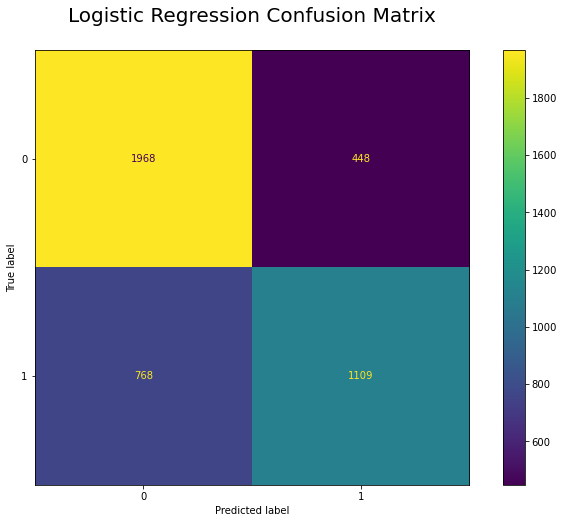

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# classifier는 GridSearchCV에서 최적 파라미터로 학습된 classifier를 그대로 이용
lg_preds = lg_grid_cv.best_estimator_.predict(tfidf_matrix_test)

# classification과 관련된 measures
print('Logistic Regression\n\n',classification_report(y_test, lg_preds))

# Confusion matrix plot
lg_cm = confusion_matrix(y_test, lg_preds, labels=lg_grid_cv.classes_)
lg_disp = ConfusionMatrixDisplay(confusion_matrix=lg_cm, display_labels=lg_grid_cv.classes_)

fig, ax = plt.subplots(figsize=(12,8))
plt.title('Logistic Regression Confusion Matrix\n', fontsize=20)
_ = lg_disp.plot(ax=ax) # _ = is used to not show < ~~~ >

## Support Vector Machine

### Training

[HP tuning reference](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769)

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Support Vector Machine
svc = SVC(random_state=0)

# 파라미터 그리드
svc_params = {'C': [0.1, 1, 10, 100]}

svc_grid_cv = GridSearchCV(svc, param_grid=svc_params, cv=5, scoring='accuracy', verbose=2)
svc_grid_cv.fit(tfidf_matrix_train, y_train)
print(svc_grid_cv.best_params_, round(svc_grid_cv.best_score_, 4))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................................ C=0.1, total=   7.9s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s


[CV] ............................................ C=0.1, total=   7.8s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   7.8s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   8.4s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   8.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   8.6s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   8.2s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   8.5s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.2min finished


{'C': 1} 0.7325


### Testing

Support Vector Machine

               precision    recall  f1-score   support

           0       0.75      0.84      0.79      2416
           1       0.75      0.64      0.69      1877

    accuracy                           0.75      4293
   macro avg       0.75      0.74      0.74      4293
weighted avg       0.75      0.75      0.75      4293



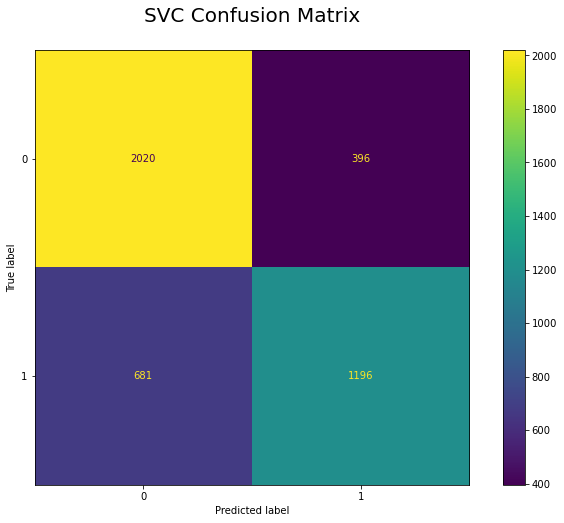

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# classifier는 GridSearchCV에서 최적 파라미터로 학습된 classifier를 그대로 이용
svc_preds = svc_grid_cv.best_estimator_.predict(tfidf_matrix_test)

# classification과 관련된 measures
print('Support Vector Machine\n\n',classification_report(y_test, svc_preds))

# Confusion matrix plot
svc_cm = confusion_matrix(y_test, svc_preds, labels=svc_grid_cv.classes_)
svc_disp = ConfusionMatrixDisplay(confusion_matrix=svc_cm, display_labels=svc_grid_cv.classes_)

fig, ax = plt.subplots(figsize=(12,8))
plt.title('SVC Confusion Matrix\n', fontsize=20)
_ = svc_disp.plot(ax=ax) # _ = is used to not show < ~~~ >

## Multinomial Naive Bayes

### Training

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Support Vector Machine
mnb = MultinomialNB()

# 파라미터 그리드
mnb_params = {'alpha': [0, 1, 10, 100]}

mnb_grid_cv = GridSearchCV(mnb, param_grid=mnb_params, cv=5, scoring='accuracy', verbose=2)
mnb_grid_cv.fit(tfidf_matrix_train, y_train)
print(mnb_grid_cv.best_params_, round(mnb_grid_cv.best_score_, 4))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] alpha=0 .........................................................
[CV] .......................................... alpha=0, total=   0.0s
[CV] alpha=0 .........................................................
[CV] .......................................... alpha=0, total=   0.0s
[CV] alpha=0 .........................................................
[CV] .......................................... alpha=0, total=   0.0s
[CV] alpha=0 .........................................................
[CV] .......................................... alpha=0, total=   0.0s
[CV] alpha=0 .........................................................
[CV] .......................................... alpha=0, total=   0.0s
[CV] alpha=1 .........................................................
[CV] .......................................... alpha=1, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


### Testing

MultinomialNB

               precision    recall  f1-score   support

           0       0.74      0.79      0.76      2416
           1       0.70      0.65      0.67      1877

    accuracy                           0.73      4293
   macro avg       0.72      0.72      0.72      4293
weighted avg       0.72      0.73      0.72      4293



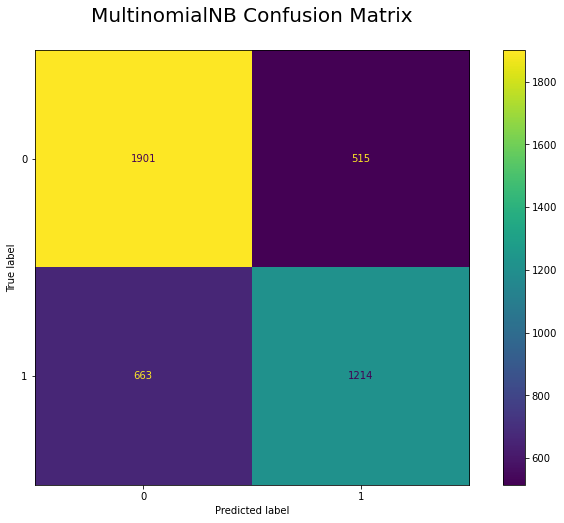

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# classifier는 GridSearchCV에서 최적 파라미터로 학습된 classifier를 그대로 이용
mnb_preds = mnb_grid_cv.best_estimator_.predict(tfidf_matrix_test)

# classification과 관련된 measures
print('MultinomialNB\n\n',classification_report(y_test, mnb_preds))

# Confusion matrix plot
mnb_cm = confusion_matrix(y_test, mnb_preds, labels=mnb_grid_cv.classes_)
mnb_disp = ConfusionMatrixDisplay(confusion_matrix=mnb_cm, display_labels=mnb_grid_cv.classes_)

fig, ax = plt.subplots(figsize=(12,8))
plt.title('MultinomialNB Confusion Matrix\n', fontsize=20)
_ = mnb_disp.plot(ax=ax) # _ = is used to not show < ~~~ >